# Collect multiple force/torque measurements as end-effector moves around, train decision tree to predict expected force.

In [1]:
import rospy

from geometry_msgs.msg import WrenchStamped
import moveit_commander
import numpy as np
from scipy.spatial.transform import Rotation as R
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
import time
from IPython import display
from matplotlib import pyplot as plt

Failed to import pyassimp, see https://github.com/ros-planning/moveit/issues/86 for more info


In [2]:
class FT_COMP():

    def __init__(self):
        rospy.init_node('ft_compensator', anonymous=True)

        self.pub = rospy.Publisher("/red/robotiq_ft_wrench_compensated",WrenchStamped,queue_size=1)

        self.robot = moveit_commander.RobotCommander()
        group_name = rospy.get_param("ft_group_name","red_arm")
        self.group = moveit_commander.MoveGroupCommander(group_name)

        data_path = rospy.get_param("ft_compensate_path","./data/")

        F = np.genfromtxt(data_path+'F_'+group_name+'.txt')
        T = np.genfromtxt(data_path+'T_'+group_name+'.txt')
        
        self.theta = np.genfromtxt(data_path+'theta_'+group_name+'.txt')

        self.Freg_x = KNeighborsRegressor(n_neighbors=1).fit(self.theta,F[:,0])
        self.Freg_y = KNeighborsRegressor(n_neighbors=1).fit(self.theta,F[:,1])
        self.Freg_z = KNeighborsRegressor(n_neighbors=1).fit(self.theta,F[:,2])
        self.Treg_x = KNeighborsRegressor(n_neighbors=1).fit(self.theta,T[:,0])
        self.Treg_y = KNeighborsRegressor(n_neighbors=1).fit(self.theta,T[:,1])
        self.Treg_z = KNeighborsRegressor(n_neighbors=1).fit(self.theta,T[:,2])
        
        self.error = []

    def run(self):
        rospy.Subscriber("/red/robotiq_ft_wrench", WrenchStamped, self.callback,queue_size=1)
        rospy.spin()

    def callback(self,msg):

        pose = self.group.get_current_pose().pose
        theta = R.from_quat(np.array((pose.orientation.x,pose.orientation.y,pose.orientation.z,pose.orientation.w)))
        theta = theta.as_euler('zyx')
        
        self.Fx = self.Freg_x.predict(theta.reshape(1,-1))
        self.Fy = self.Freg_y.predict(theta.reshape(1,-1))
        self.Fz = self.Freg_z.predict(theta.reshape(1,-1))
        
        self.Tx = self.Treg_x.predict(theta.reshape(1,-1))
        self.Ty = self.Treg_y.predict(theta.reshape(1,-1))
        self.Tz = self.Treg_z.predict(theta.reshape(1,-1))

        msg_new = msg
        msg_new.wrench.force.x = msg.wrench.force.x - self.Fx
        msg_new.wrench.force.y = msg.wrench.force.y - self.Fy
        msg_new.wrench.force.z = msg.wrench.force.z - self.Fz

        msg_new.wrench.torque.x = msg.wrench.torque.x - self.Tx
        msg_new.wrench.torque.y = msg.wrench.torque.y - self.Ty
        msg_new.wrench.torque.z = msg.wrench.torque.z - self.Tz

        f_diff = np.sqrt(msg_new.wrench.force.x**2 + msg_new.wrench.force.y**2 + msg_new.wrench.force.z**2)
        t_diff = np.sqrt(msg_new.wrench.torque.x**2 + msg_new.wrench.torque.y**2 + msg_new.wrench.torque.z**2)
        self.error.append(np.array([msg_new.wrench.force.x,msg_new.wrench.force.y,msg_new.wrench.force.z]))
        self.pub.publish(msg_new)
        
        plt.clf()
#         plt.subplot(2,3,1)
#         plt.hist(self.theta[:,0],alpha=0.5,bins=100)
#         plt.plot([theta[0],theta[0]],[0,300],'r--')
#         plt.title(f_diff)
#         plt.subplot(2,3,2)
#         plt.hist(self.theta[:,1],alpha=0.5,bins=100)
#         plt.plot([theta[1],theta[1]],[0,300],'r--')
#         plt.title(t_diff)
#         plt.subplot(2,3,3)
#         plt.hist(self.theta[:,2],alpha=0.5,bins=100)
#         plt.plot([theta[2],theta[2]],[0,300],'r--')
        plt.subplot(2,3,1)
        plt.hist2d(self.theta[:,0],self.theta[:,1],bins=20)
        plt.plot(theta[0],theta[1],'r+')
        plt.title('F error %2.2f'%f_diff)
        plt.subplot(2,3,2)
        plt.hist2d(self.theta[:,0],self.theta[:,2],bins=20)
        plt.plot(theta[0],theta[2],'r+')
        plt.subplot(2,3,3)
        plt.hist2d(self.theta[:,1],self.theta[:,2],bins=20)
        plt.plot(theta[1],theta[2],'r+')
        plt.subplot(2,3,4)
        plt.hist(np.array(self.error)[:,0],alpha=0.5)
        plt.subplot(2,3,5)
        plt.hist(np.array(self.error)[:,1],alpha=0.5)
        plt.subplot(2,3,6)
        plt.hist(np.array(self.error)[:,2],alpha=0.5)
        
        display.clear_output(wait=True)
        display.display(plt.gcf())

In [3]:
ft = FT_COMP()

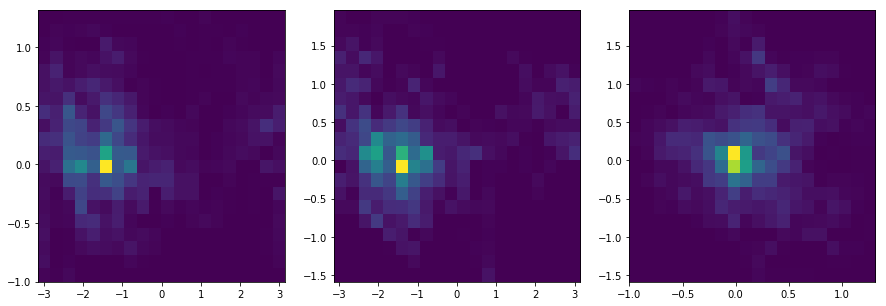

In [4]:
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.hist2d(ft.theta[:,0],ft.theta[:,1],bins=20)
plt.subplot(1,3,2)
plt.hist2d(ft.theta[:,0],ft.theta[:,2],bins=20)
plt.subplot(1,3,3)
plt.hist2d(ft.theta[:,1],ft.theta[:,2],bins=20)
plt.show()

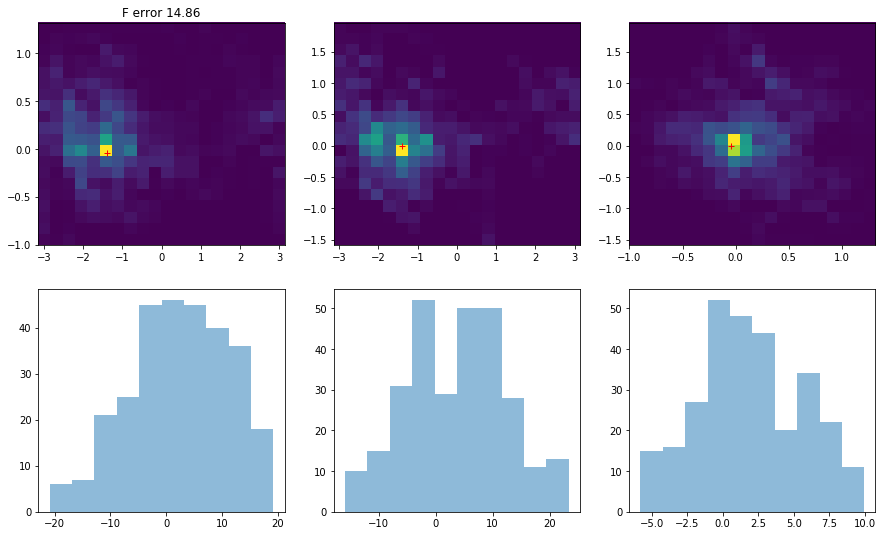

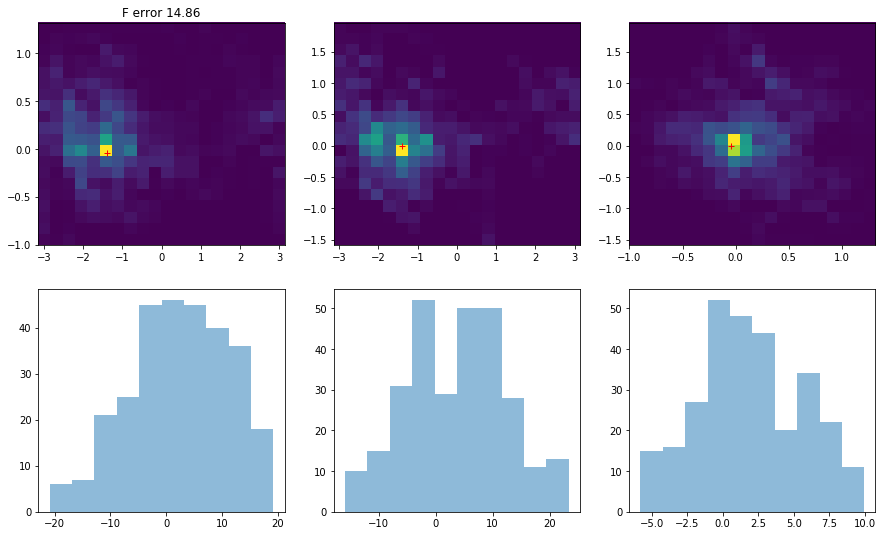

In [5]:
plt.figure(figsize=(15,9))
ft.run()